In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [31]:
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import dill as pickle

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from src.group_ts_split import PurgedGroupTimeSeriesSplit

import seaborn as sns
import matplotlib.pyplot as plt

import cpadapter
from cpadapter.utils import train_cal_test_split
from cpadapter.visualization import conditional_band_interval_plot
from optuna.samplers import TPESampler
import optuna

In [3]:
# Path to the table with metadata
meta_pre = './data/EANLIJST_METADATA.csv'
# Input data directory
input_dir = './data/'

In [19]:
data = pd.read_csv(input_dir+'full.csv')
data.index = pd.to_datetime(data.datetime)

In [13]:
# CV PARAMS
FOLDS = 10
GROUP_GAP = 1
MAX_TEST_GROUP_SIZE = 30
MAX_TRAIN_GROUP_SIZE = 100

# define features for LGBM
features = data.columns.drop(['Target', 'ID','datetime', 'type', 'kwh', 'Target-1', 'Target-7'])
features = features.to_list()
categoricals = data.columns.drop(['Target', 'ID', 'yearly_cons','datetime', 'type', 'kwh','Target-1', 'Target-7'])
categoricals = categoricals.to_list()

In [26]:
labelencoder = preprocessing.LabelEncoder()

for col in categoricals:
    data[col] = labelencoder.fit_transform(data[col])
    data[col] = data[col].astype('int')

In [15]:
X = data[features]
y = data['Target']
dateda = pd.to_datetime(data['datetime'])
groups = pd.factorize(dateda.dt.day.astype(str) + '_' + dateda.dt.month.astype(str) + '_' + dateda.dt.year.astype(str))[0]

In [42]:
evals_result = {}
sampler = TPESampler(seed = 123)

def objective(trial):
    params = {
        'objective': 'regression_l1', #'regression'
        'random_state': 123,
        'verbose': -1,
        'max_depth': trial.suggest_int('max_depth',3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        #'n_estimators': trial.suggest_categorical('n_estimators', [10000]),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }
        
    # 10-fold time-series cross validation
    tfold = PurgedGroupTimeSeriesSplit(n_splits = FOLDS, group_gap = GROUP_GAP, max_train_group_size = MAX_TRAIN_GROUP_SIZE, max_test_group_size = MAX_TEST_GROUP_SIZE)
    mae_list = []
    for _, (train_index, test_index) in tqdm(enumerate(tfold.split(X, y, groups))):
        X_train = X.iloc[train_index]
        X_val = X.iloc[test_index]
        y_train = y[train_index]
        y_val = y[test_index]        
        train_dataset = lgb.Dataset(X_train, 
                            y_train, 
                            feature_name = features, 
                            categorical_feature = categoricals,
                            free_raw_data=False)
        val_dataset = lgb.Dataset(X_val, 
                                y_val,
                                feature_name = features, 
                                categorical_feature = categoricals,
                                free_raw_data=False)
        # train LGBM2
        model = lgb.train(params = params,
                          train_set = train_dataset, 
                          valid_sets = [val_dataset],
                          early_stopping_rounds=100,
                          verbose_eval = 10,
                          evals_result = evals_result 
                         )
        pred = model.predict(val_dataset.get_data())

        mae = mean_absolute_error(np.nan_to_num(pred), np.nan_to_num(val_dataset.get_label()))
        mae_list.append(mae)
        #print(pcc_list)
    print(f'\n average PCC: {np.mean(mae_list):.4f}')
    return np.mean(mae_list)

In [43]:
#study_model = optuna.create_study(direction = 'maximize', sampler = sampler)
study_model = optuna.create_study(direction = 'minimize', sampler = sampler)
study_model.optimize(objective, n_trials = 50)

[I 2022-06-13 09:15:34,831] A new study created in memory with name: no-name-69ca2e14-15ae-42fa-bdc8-57dc7913e504
0it [00:00, ?it/s]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.f

Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.45558e-06
[20]	valid_0's l1: 6.45833e-06
[30]	valid_0's l1: 6.45841e-06
[40]	valid_0's l1: 6.45856e-06
[50]	valid_0's l1: 6.45856e-06
[60]	valid_0's l1: 6.45856e-06
[70]	valid_0's l1: 6.45856e-06
[80]	valid_0's l1: 6.45856e-06
[90]	valid_0's l1: 6.45856e-06


1it [00:48, 48.15s/it]

[100]	valid_0's l1: 6.45856e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 6.45558e-06


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.22714e-06
[20]	valid_0's l1: 6.22756e-06
[30]	valid_0's l1: 6.22756e-06
[40]	valid_0's l1: 6.22756e-06
[50]	valid_0's l1: 6.22865e-06
[60]	valid_0's l1: 6.22865e-06
[70]	valid_0's l1: 6.22865e-06
[80]	valid_0's l1: 6.22865e-06
[90]	valid_0's l1: 6.22865e-06
[100]	valid_0's l1: 6.22865e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 6.22714e-06


2it [01:09, 32.55s/it]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.02756e-06
[20]	valid_0's l1: 6.02785e-06
[30]	valid_0's l1: 6.02785e-06
[40]	valid_0's l1: 6.02785e-06
[50]	valid_0's l1: 6.02802e-06
[60]	valid_0's l1: 6.02802e-06
[70]	valid_0's l1: 6.02802e-06
[80]	valid_0's l1: 6.02802e-06
[90]	valid_0's l1: 6.02802e-06
[100]	valid_0's l1: 6.0289e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 6.02756e-06


3it [01:31, 27.65s/it]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 9.43175e-06
[20]	valid_0's l1: 9.43175e-06
[30]	valid_0's l1: 9.43175e-06
[40]	valid_0's l1: 9.43175e-06
[50]	valid_0's l1: 9.43175e-06
[60]	valid_0's l1: 9.43175e-06
[70]	valid_0's l1: 9.43175e-06
[80]	valid_0's l1: 9.43175e-06
[90]	valid_0's l1: 9.43175e-06


4it [01:49, 23.68s/it]

[100]	valid_0's l1: 9.43213e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 9.43175e-06


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 8.66829e-06
[20]	valid_0's l1: 8.66933e-06
[30]	valid_0's l1: 8.66844e-06
[40]	valid_0's l1: 8.66844e-06
[50]	valid_0's l1: 8.66844e-06
[60]	valid_0's l1: 8.66844e-06
[70]	valid_0's l1: 8.66844e-06
[80]	valid_0's l1: 8.66844e-06
[90]	valid_0's l1: 8.66844e-06
[100]	valid_0's l1: 8.66844e-06


5it [01:59, 18.73s/it]

Early stopping, best iteration is:
[9]	valid_0's l1: 8.66829e-06


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 1.59452e-05
[20]	valid_0's l1: 1.59455e-05
[30]	valid_0's l1: 1.59456e-05
[40]	valid_0's l1: 1.59456e-05
[50]	valid_0's l1: 1.59457e-05
[60]	valid_0's l1: 1.59457e-05
[70]	valid_0's l1: 1.59457e-05
[80]	valid_0's l1: 1.59458e-05
[90]	valid_0's l1: 1.59487e-05


6it [02:10, 16.06s/it]

[100]	valid_0's l1: 1.59518e-05
Early stopping, best iteration is:
[1]	valid_0's l1: 1.59452e-05


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 1.66523e-05
[20]	valid_0's l1: 1.66584e-05
[30]	valid_0's l1: 1.6677e-05
[40]	valid_0's l1: 1.6696e-05
[50]	valid_0's l1: 1.6696e-05
[60]	valid_0's l1: 1.6696e-05
[70]	valid_0's l1: 1.66968e-05
[80]	valid_0's l1: 1.66966e-05
[90]	valid_0's l1: 1.66979e-05


7it [02:20, 14.08s/it]

[100]	valid_0's l1: 1.66979e-05
Early stopping, best iteration is:
[1]	valid_0's l1: 1.66445e-05


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 2.70421e-05
[20]	valid_0's l1: 2.70421e-05
[30]	valid_0's l1: 2.70425e-05
[40]	valid_0's l1: 2.70425e-05
[50]	valid_0's l1: 2.70425e-05
[60]	valid_0's l1: 2.70945e-05
[70]	valid_0's l1: 2.70945e-05
[80]	valid_0's l1: 2.70945e-05
[90]	valid_0's l1: 2.7109e-05
[100]	valid_0's l1: 2.7109e-05
Early stopping, best iteration is:
[1]	valid_0's l1: 2.70421e-05


8it [02:35, 14.45s/it]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 4.9783e-05
[20]	valid_0's l1: 4.9783e-05
[30]	valid_0's l1: 4.9783e-05
[40]	valid_0's l1: 4.9783e-05
[50]	valid_0's l1: 4.9783e-05
[60]	valid_0's l1: 4.97836e-05
[70]	valid_0's l1: 4.97847e-05
[80]	valid_0's l1: 4.97847e-05
[90]	valid_0's l1: 4.97847e-05


9it [02:52, 15.23s/it]

[100]	valid_0's l1: 4.97848e-05
Early stopping, best iteration is:
[1]	valid_0's l1: 4.9783e-05


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 8.33784e-05
[20]	valid_0's l1: 8.33822e-05
[30]	valid_0's l1: 8.33822e-05
[40]	valid_0's l1: 8.33902e-05
[50]	valid_0's l1: 8.33941e-05
[60]	valid_0's l1: 8.33968e-05
[70]	valid_0's l1: 8.33969e-05
[80]	valid_0's l1: 8.34135e-05
[90]	valid_0's l1: 8.34136e-05


10it [03:04, 14.31s/it]

[100]	valid_0's l1: 8.34136e-05
Early stopping, best iteration is:
[1]	valid_0's l1: 8.33784e-05


10it [03:06, 18.61s/it]
[I 2022-06-13 09:18:41,124] Trial 0 finished with value: 2.2960348590201555e-05 and parameters: {'max_depth': 15, 'num_leaves': 74, 'learning_rate': 0.02269287684188467, 'n_estimators': 1603, 'feature_fraction': 0.8316813818713378, 'bagging_fraction': 0.6538638760746767, 'bagging_freq': 7, 'min_child_samples': 36, 'lambda_l1': 0.00021300368327705253, 'lambda_l2': 3.381097259762742e-05}. Best is trial 0 with value: 2.2960348590201555e-05.



 average PCC: 0.0000


0it [00:00, ?it/s]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.45558e-06
[20]	valid_0's l1: 6.45558e-06
[30]	valid_0's l1: 6.45558e-06
[40]	valid_0's l1: 6.45558e-06
[50]	valid_0's l1: 6.45558e-06
[60]	valid_0's l1: 6.45558e-06
[70]	valid_0's l1: 6.45558e-06
[80]	valid_0's l1: 6.45558e-06
[90]	valid_0's l1: 6.45558e-06


1it [00:50, 50.84s/it]

[100]	valid_0's l1: 6.45558e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 6.45558e-06


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.22714e-06
[20]	valid_0's l1: 6.22714e-06
[30]	valid_0's l1: 6.22714e-06
[40]	valid_0's l1: 6.22714e-06
[50]	valid_0's l1: 6.22714e-06
[60]	valid_0's l1: 6.22714e-06
[70]	valid_0's l1: 6.22714e-06
[80]	valid_0's l1: 6.22714e-06
[90]	valid_0's l1: 6.22714e-06
[100]	valid_0's l1: 6.22714e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 6.22714e-06


2it [01:19, 37.79s/it]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.02756e-06
[20]	valid_0's l1: 6.02756e-06
[30]	valid_0's l1: 6.02756e-06
[40]	valid_0's l1: 6.02756e-06
[50]	valid_0's l1: 6.02756e-06
[60]	valid_0's l1: 6.02756e-06
[70]	valid_0's l1: 6.02756e-06
[80]	valid_0's l1: 6.02756e-06
[90]	valid_0's l1: 6.02756e-06
[100]	valid_0's l1: 6.02756e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 6.02756e-06


3it [01:46, 32.76s/it]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 9.43175e-06
[20]	valid_0's l1: 9.43175e-06
[30]	valid_0's l1: 9.43175e-06
[40]	valid_0's l1: 9.43175e-06
[50]	valid_0's l1: 9.43175e-06
[60]	valid_0's l1: 9.43175e-06
[70]	valid_0's l1: 9.43175e-06
[80]	valid_0's l1: 9.43175e-06
[90]	valid_0's l1: 9.43175e-06
[100]	valid_0's l1: 9.43175e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 9.43175e-06


4it [02:14, 31.08s/it]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 8.68003e-06
[20]	valid_0's l1: 8.68003e-06
[30]	valid_0's l1: 8.68003e-06
[40]	valid_0's l1: 8.68003e-06
[50]	valid_0's l1: 8.68003e-06
[60]	valid_0's l1: 8.68003e-06
[70]	valid_0's l1: 8.68003e-06
[80]	valid_0's l1: 8.68003e-06
[90]	valid_0's l1: 8.68003e-06
[100]	valid_0's l1: 8.68003e-06


5it [02:41, 29.47s/it]

Early stopping, best iteration is:
[1]	valid_0's l1: 8.68003e-06


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 1.59452e-05
[20]	valid_0's l1: 1.59452e-05
[30]	valid_0's l1: 1.59452e-05
[40]	valid_0's l1: 1.59452e-05
[50]	valid_0's l1: 1.59452e-05
[60]	valid_0's l1: 1.59452e-05
[70]	valid_0's l1: 1.59452e-05
[80]	valid_0's l1: 1.59452e-05
[90]	valid_0's l1: 1.59452e-05
[100]	valid_0's l1: 1.59452e-05


6it [03:09, 29.03s/it]

Early stopping, best iteration is:
[1]	valid_0's l1: 1.59452e-05


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 1.66418e-05
[20]	valid_0's l1: 1.66418e-05
[30]	valid_0's l1: 1.66418e-05
[40]	valid_0's l1: 1.66418e-05
[50]	valid_0's l1: 1.66418e-05
[60]	valid_0's l1: 1.66418e-05
[70]	valid_0's l1: 1.66418e-05
[80]	valid_0's l1: 1.66418e-05
[90]	valid_0's l1: 1.66418e-05
[100]	valid_0's l1: 1.66418e-05


7it [03:34, 27.59s/it]

Early stopping, best iteration is:
[1]	valid_0's l1: 1.66418e-05


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 2.70225e-05
[20]	valid_0's l1: 2.70225e-05
[30]	valid_0's l1: 2.70223e-05
[40]	valid_0's l1: 2.70223e-05
[50]	valid_0's l1: 2.70222e-05
[60]	valid_0's l1: 2.70222e-05
[70]	valid_0's l1: 2.70222e-05
[80]	valid_0's l1: 2.70222e-05
[90]	valid_0's l1: 2.70222e-05
[100]	valid_0's l1: 2.70222e-05


8it [03:56, 26.04s/it]

Early stopping, best iteration is:
[1]	valid_0's l1: 2.70156e-05


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 4.9783e-05
[20]	valid_0's l1: 4.9783e-05
[30]	valid_0's l1: 4.9783e-05
[40]	valid_0's l1: 4.9783e-05
[50]	valid_0's l1: 4.9783e-05
[60]	valid_0's l1: 4.9783e-05
[70]	valid_0's l1: 4.9783e-05
[80]	valid_0's l1: 4.9783e-05
[90]	valid_0's l1: 4.9783e-05
[100]	valid_0's l1: 4.9783e-05
Early stopping, best iteration is:
[1]	valid_0's l1: 4.9783e-05


9it [04:19, 25.06s/it]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 8.33784e-05
[20]	valid_0's l1: 8.33784e-05
[30]	valid_0's l1: 8.33784e-05
[40]	valid_0's l1: 8.33784e-05
[50]	valid_0's l1: 8.33784e-05
[60]	valid_0's l1: 8.33784e-05
[70]	valid_0's l1: 8.33784e-05
[80]	valid_0's l1: 8.33784e-05
[90]	valid_0's l1: 8.33784e-05


10it [04:43, 24.69s/it]

[100]	valid_0's l1: 8.33784e-05
Early stopping, best iteration is:
[1]	valid_0's l1: 8.33784e-05


10it [04:44, 28.47s/it]
[I 2022-06-13 09:23:25,959] Trial 1 finished with value: 2.295861361778025e-05 and parameters: {'max_depth': 9, 'num_leaves': 187, 'learning_rate': 0.04386283874551565, 'n_estimators': 619, 'feature_fraction': 0.6388265531982589, 'bagging_fraction': 0.8427972434392215, 'bagging_freq': 2, 'min_child_samples': 13, 'lambda_l1': 0.0006080823033339466, 'lambda_l2': 0.0006115729720282377}. Best is trial 1 with value: 2.295861361778025e-05.



 average PCC: 0.0000


0it [00:00, ?it/s]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.45558e-06
[20]	valid_0's l1: 6.46228e-06
[30]	valid_0's l1: 6.46228e-06
[40]	valid_0's l1: 6.46228e-06
[50]	valid_0's l1: 6.46258e-06
[60]	valid_0's l1: 6.46258e-06
[70]	valid_0's l1: 6.47391e-06
[80]	valid_0's l1: 6.49171e-06
[90]	valid_0's l1: 6.49171e-06
[100]	valid_0's l1: 6.50176e-06


1it [00:54, 54.59s/it]

Early stopping, best iteration is:
[1]	valid_0's l1: 6.45558e-06


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.22769e-06
[20]	valid_0's l1: 6.22769e-06
[30]	valid_0's l1: 6.232e-06
[40]	valid_0's l1: 6.23669e-06
[50]	valid_0's l1: 6.23669e-06
[60]	valid_0's l1: 6.23966e-06
[70]	valid_0's l1: 6.23966e-06
[80]	valid_0's l1: 6.23966e-06
[90]	valid_0's l1: 6.23966e-06
[100]	valid_0's l1: 6.24413e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 6.22714e-06


2it [01:21, 38.46s/it]/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 6.02756e-06
[20]	valid_0's l1: 6.02756e-06
[30]	valid_0's l1: 6.02756e-06
[40]	valid_0's l1: 6.02756e-06
[50]	valid_0's l1: 6.03112e-06
[60]	valid_0's l1: 6.03112e-06
[70]	valid_0's l1: 6.03112e-06
[80]	valid_0's l1: 6.03435e-06
[90]	valid_0's l1: 6.04311e-06


3it [01:48, 33.04s/it]

[100]	valid_0's l1: 6.05658e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 6.02756e-06


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 9.43175e-06
[20]	valid_0's l1: 9.43405e-06
[30]	valid_0's l1: 9.43405e-06
[40]	valid_0's l1: 9.43492e-06
[50]	valid_0's l1: 9.43461e-06
[60]	valid_0's l1: 9.43845e-06
[70]	valid_0's l1: 9.43845e-06
[80]	valid_0's l1: 9.43862e-06
[90]	valid_0's l1: 9.43854e-06
[100]	valid_0's l1: 9.43854e-06


4it [02:16, 31.17s/it]

Early stopping, best iteration is:
[1]	valid_0's l1: 9.43175e-06


/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/anaconda3/envs/generate/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[10]	valid_0's l1: 8.67304e-06
[20]	valid_0's l1: 8.85039e-06
[30]	valid_0's l1: 8.85039e-06
[40]	valid_0's l1: 8.83825e-06
[50]	valid_0's l1: 8.93583e-06
[60]	valid_0's l1: 8.93583e-06
[70]	valid_0's l1: 8.93595e-06
[80]	valid_0's l1: 8.93279e-06
[90]	valid_0's l1: 8.92174e-06


5it [02:43, 29.56s/it]

[100]	valid_0's l1: 9.04215e-06
Early stopping, best iteration is:
[1]	valid_0's l1: 8.67304e-06


In [ ]:
# select best trial and parameter
trial = study_model.best_trial
best_params = trial.params

print('Best params from optuna: \n', best_params)

In [ ]:
# Save the best parameters into a json file
with open('params.json', 'wb') as fp:
    pickle.dump(best_params, fp)

In [11]:
with open('params.json', 'rb') as fp:
    best_params = pickle.load(fp)
best_params

{'max_depth': 14,
 'num_leaves': 70,
 'learning_rate': 0.09544600078958534,
 'n_estimators': 504,
 'feature_fraction': 0.692597562668158,
 'bagging_fraction': 0.902059664353617,
 'bagging_freq': 2,
 'min_child_samples': 7,
 'lambda_l1': 1.8770358603329745e-05,
 'lambda_l2': 0.007252894722583617}

In [27]:
split_date = pd.to_datetime(data.datetime)[int(len(data) * 0.93)]

x_train, y_train = data.loc[data.index < split_date][features], data.loc[data.index < split_date]['Target']
x_cal, y_cal = data.loc[data.index >= split_date][features], data.loc[data.index >= split_date]['Target']
train_dataset = lgb.Dataset(x_train, 
                        y_train, 
                        feature_name = features, 
                        categorical_feature = categoricals,
                        free_raw_data=False).construct()
cal_dataset = lgb.Dataset(x_cal, 
                        y_cal, 
                        feature_name = features, 
                        categorical_feature = categoricals,
                        free_raw_data=False).construct()

In [39]:
# CHECK ADEQUACY 
lgbmod = LGBMRegressor(**best_params)
cp_model = cpadapter.Adapt_to_CP(lgbmod, True)
#cv_result(lgb_model, X, y)
cp_model.fit(train_dataset.get_data(), train_dataset.get_label())
cp_model.calibrate(cal_dataset.get_data(), cal_dataset.get_label())

In [41]:
# save model
pickle.dump(cp_model, open('train_prob_vvsg.p', 'wb'))

# save model
pickle.dump(model, open('train_vvsg.p', 'wb'))

In [37]:
lgbmod = LGBMRegressor(**best_params)
model = lgbmod.fit(train_dataset.get_data(), train_dataset.get_label())

[LightGBM] [Warning] lambda_l1 is set=1.8770358603329745e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8770358603329745e-05
[LightGBM] [Warning] feature_fraction is set=0.692597562668158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692597562668158
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.007252894722583617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007252894722583617
[LightGBM] [Warning] bagging_fraction is set=0.902059664353617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.902059664353617


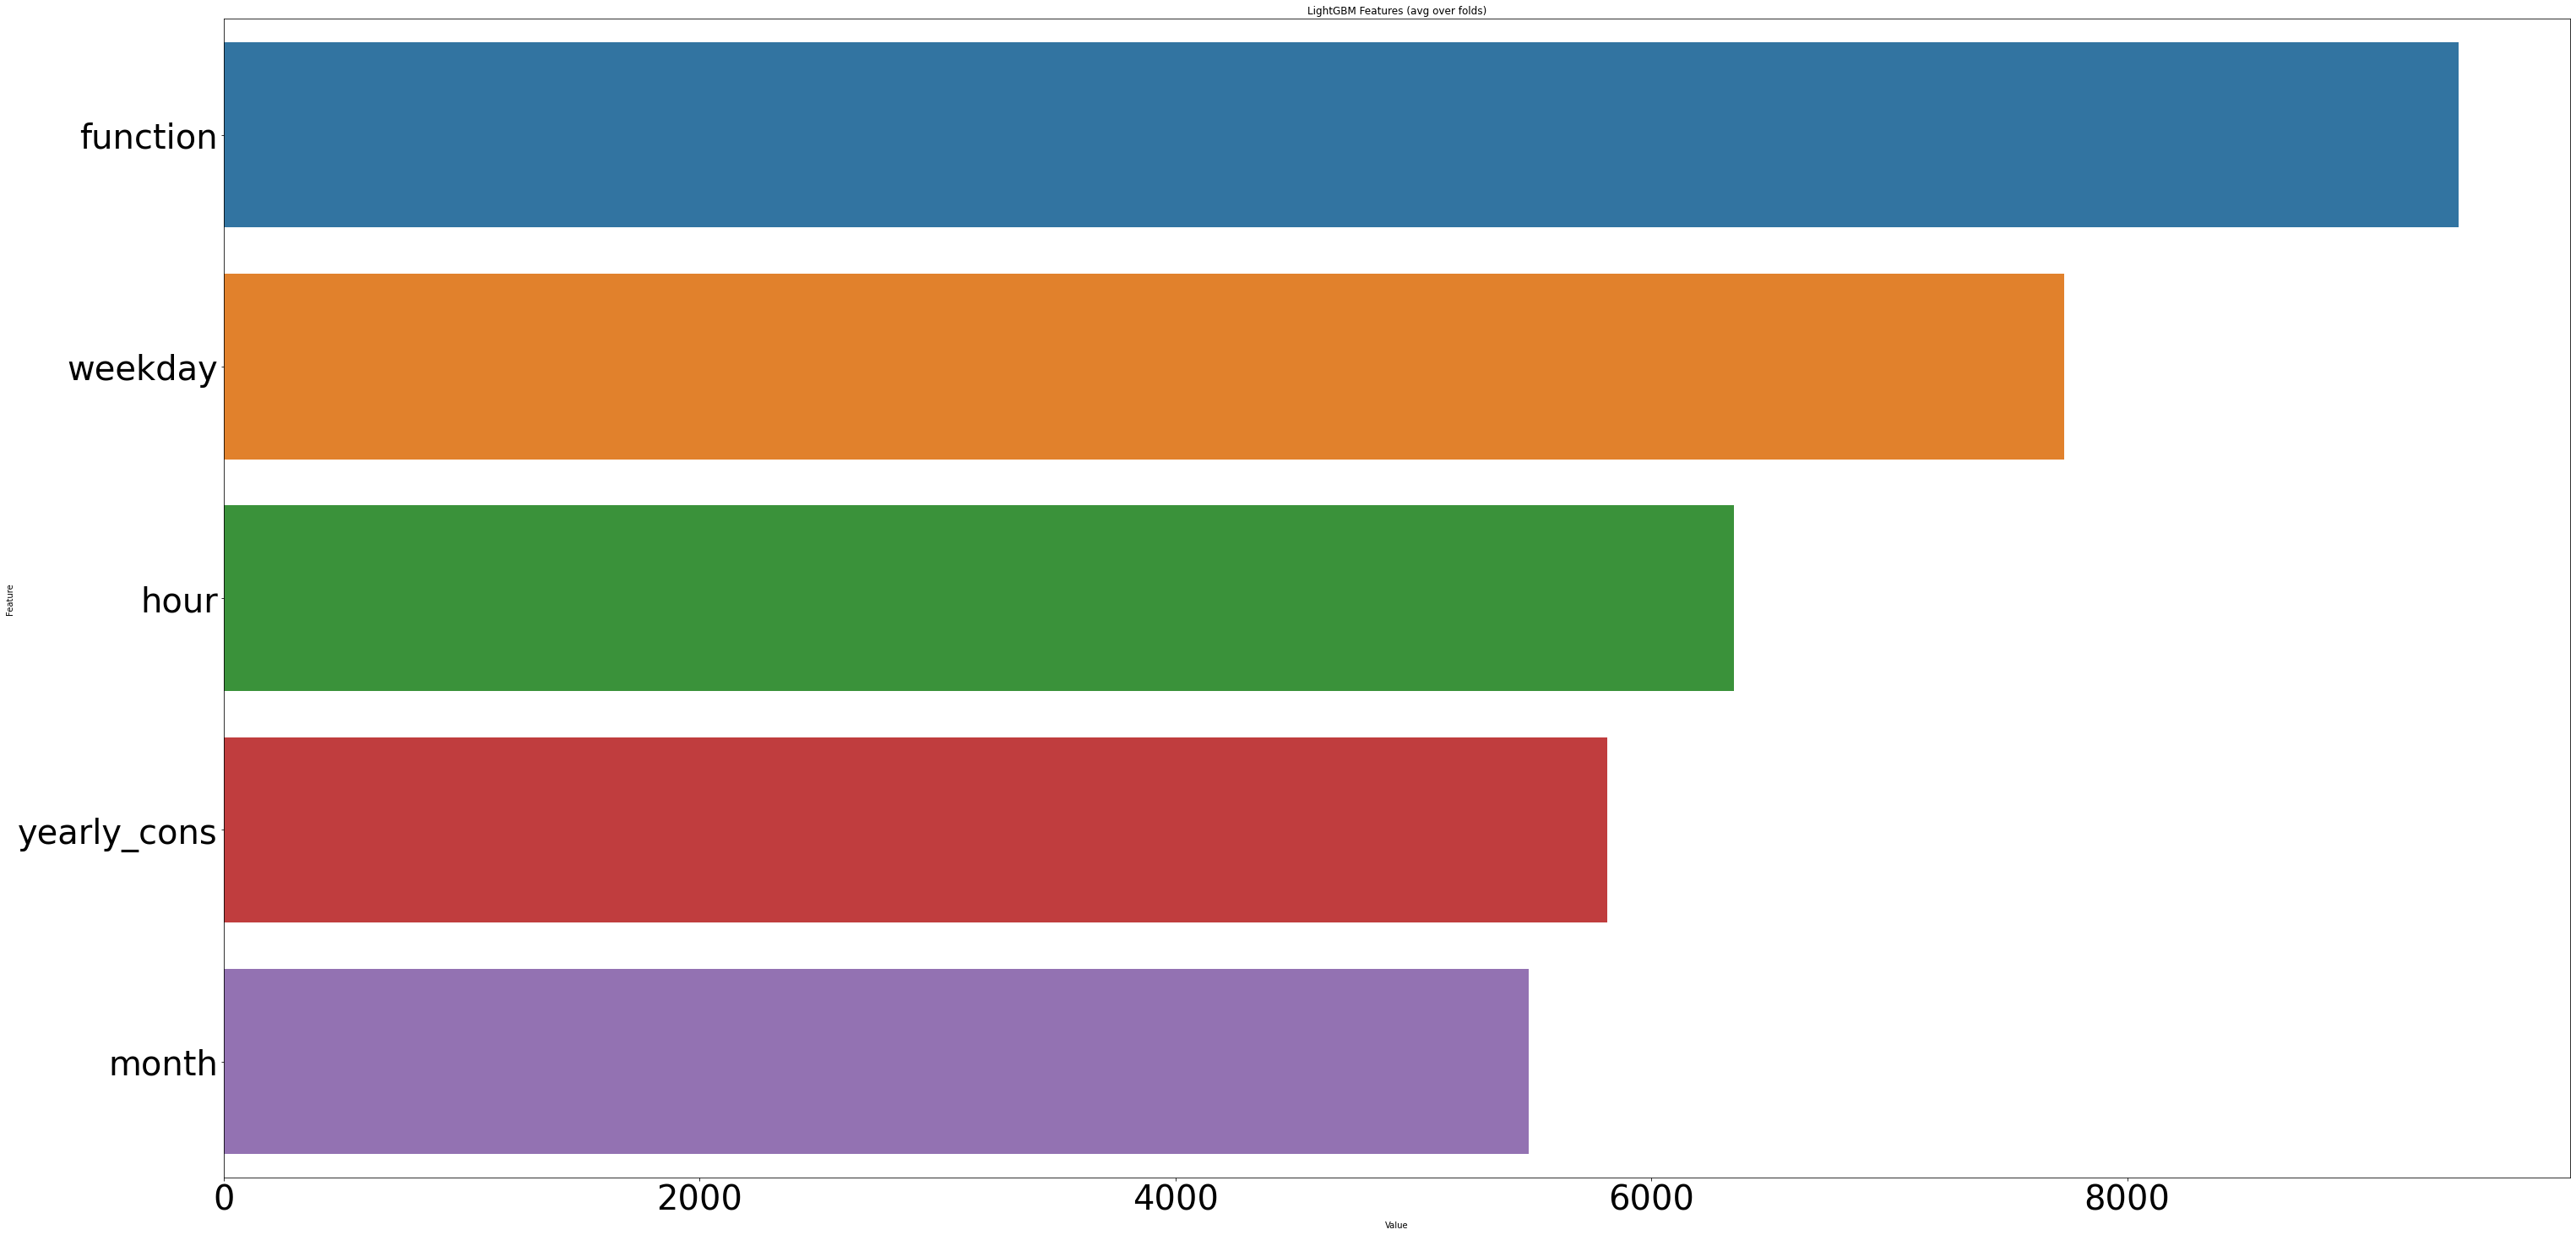

In [38]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    #sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    #plt.savefig('lgbm_importances-01.png')
    plt.show()

plotImp(model, train_dataset.get_data())

In [37]:
df_test = data[data.ID == 6725][-168:]
X_test = df_test[features]
y_test = df_test['Target']
test_dataset = lgb.Dataset(X_test, 
                            y_test, 
                            feature_name = features, 
                            categorical_feature = categoricals,
                            free_raw_data=False).construct()
y_preds = np.zeros((len(test_dataset.get_label())))
y_preds = model.predict(test_dataset.get_data())

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


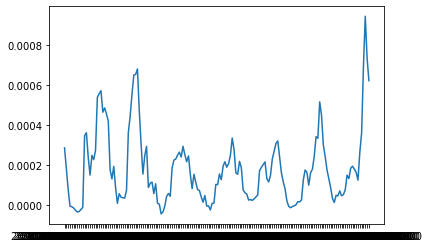

In [38]:
plt.plot(df_test['datetime'], y_preds)
plt.show()

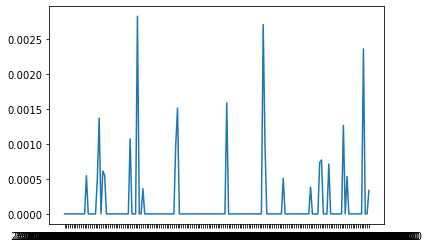

In [39]:
plt.plot(df_test['datetime'], y_test)
plt.show()